
Begin simulations 

Simulation 1 complete
Simulation 2 complete
Simulation 3 complete
Simulation 4 complete
Simulation 5 complete
Simulation 6 complete
Simulation 7 complete
Simulation 8 complete
Simulation 9 complete
Simulation 10 complete

Begin EWS computation

EWS for realisation 1 complete
EWS for realisation 2 complete
EWS for realisation 3 complete
EWS for realisation 4 complete
EWS for realisation 5 complete
EWS for realisation 6 complete
EWS for realisation 7 complete
EWS for realisation 8 complete
EWS for realisation 9 complete
EWS for realisation 10 complete


Text(0, 0.5, 'beta')

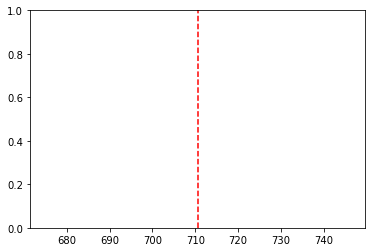

In [10]:
# import python libraries
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ewstools


#--------------------------------
# Global parameters
#–-----------------------------


# Simulation parameters
dt = 0.01
t0 = 0
tmax = 1500
tburn = 100 # burn-in period
numSims = 10
seed = 0 # random number generation seed

# EWS parameters
dt2 = 1 # spacing between time-series for EWS computation
rw = 0.25 # rolling window
span=0.2 # span for Lowess smoothing
lags = [1] # autocorrelation lag times
ews = ['var','ac']

#----------------------------------
# Simulate many (transient) realisations
#----------------------------------

# Model (see gellner et al. 2016)

def de_fun_S(S,I,Lambda,beta,mu):
    return Lambda-beta*S*I-mu*S

def de_fun_I(S,I,beta,alpha,mu):
    return beta*S*I- alpha*I-mu*I
    
# Model parameters
#sf = 4 # scale factor
sigma_S = 0.05 # noise intensity
sigma_I = 0.05
Lambda = 10
mu=0.1
alpha=1
betal = 0.001 # control parameter initial value
#betah = 0.002# control parameter final value
betah = 0.02# control parameter final value
betabif = 0.01# bifurcation point (computed in Mathematica)
S0 = 73.338 # intial condition (equilibrium value computed in Mathematica)
I0 = 2.424


# initialise DataFrame for each variable to store all realisations
df_sims_S = pd.DataFrame([])
df_sims_I = pd.DataFrame([])

# Initialise arrays to store single time-series data
t = np.arange(t0,tmax,dt)
S = np.zeros(len(t))
I = np.zeros(len(t))

# Set up control parameter a, that increases linearly in time from al to ah
#R0 = pd.Series(np.linspace(betal/(alpha+mu),betah/(alpha+mu),len(t)),index=t)
#R_0 = beta/(alpha+mu);
beta = pd.Series(np.linspace(betal,betah,len(t)),index=t)
#R_0 = beta/(alpha+mu);
# Time at which bifurcation occurs
tbif = beta[beta > betabif].index[1]
#print('tbif')

## Implement Euler Maryuyama for stocahstic simulation


# Set seed
np.random.seed(seed)

# Initialise a list to collect trajectories
list_traj_append = []

# loop over simulations
print('\nBegin simulations \n')
for j in range(numSims):
    
    
    # Create brownian increments (s.d. sqrt(dt)) create a array with mean o s.d. 
    dW_S_burn = np.random.normal(loc=0, scale=sigma_S*np.sqrt(dt), size = int(tburn/dt))
    dW_S = np.random.normal(loc=0, scale=sigma_S*np.sqrt(dt), size = len(t))
    
    dW_I_burn = np.random.normal(loc=0, scale=sigma_I*np.sqrt(dt), size = int(tburn/dt))
    dW_I = np.random.normal(loc=0, scale=sigma_I*np.sqrt(dt), size = len(t))
    
    # Run burn-in period on x0
    for i in range(int(tburn/dt)):
        S0 = S0 + de_fun_S(S0,I0,Lambda,beta[0],mu)*dt + dW_S_burn[i]
        I0 = I0 + de_fun_I(S0,I0,beta[0],alpha,mu)*dt + dW_I_burn[i]
        
    # Initial condition post burn-in period
    S[0]=S0
    I[0]=I0
    
    # Run simulation
    for i in range(len(t)-1):
        S[i+1] = S[i] + de_fun_S(S[i],I[i],Lambda,beta.iloc[i],mu)*dt + dW_S[i]
        I[i+1] = I[i] + de_fun_I(S[i],I[i], beta.iloc[i],alpha,mu)*dt + dW_I[i]
        # make sure that state variable remains >= 0 
        if S[i+1] < 0:
            S[i+1] = 0
        if I[i+1] < 0:
            I[i+1] = 0
            
    # Store series data in a temporary DataFrame
    data = {'tsid': (j+1)*np.ones(len(t)),
                'Time': t,
                'S': S,
                'I': I}
    df_temp = pd.DataFrame(data)
    # Append to list
    list_traj_append.append(df_temp)
    
    print('Simulation '+str(j+1)+' complete')

#  Concatenate DataFrame from each realisation
df_traj = pd.concat(list_traj_append)
df_traj.set_index(['tsid','Time'], inplace=True)


#----------------------
# Compute EWS for each simulation in x and y
#---------------------

# Filter time-series to have time-spacing dt2
df_traj_filt = df_traj.loc[::int(dt2/dt)]

# set up a list to store output dataframes from ews_compute- we will concatenate them at the end
appended_ews = []
appended_pspec = []

# loop through realisation number
print('\nBegin EWS computation\n')
for i in range(numSims):
    # loop through variable
    for var in ['S','I']:
        
        ews_dic = ewstools.core.ews_compute(df_traj_filt.loc[i+1][var], 
                          roll_window = rw, 
                          smooth='Lowess',
                          span = span,
                          lag_times = lags, 
                          ews = ews,
                          upto=tbif)
        
        # The DataFrame of EWS
        df_ews_temp = ews_dic['EWS metrics']
      
        # Include a column in the DataFrames for realisation number and variable
        df_ews_temp['tsid'] = i+1
        df_ews_temp['Variable'] = var
                        
        # Add DataFrames to list
        appended_ews.append(df_ews_temp)
        
    # Print status every realisation
    if np.remainder(i+1,1)==0:
        print('EWS for realisation '+str(i+1)+' complete')


# Concatenate EWS DataFrames. Index [tsid, Variable, Time]
df_ews = pd.concat(appended_ews).reset_index().set_index(['tsid','Variable','Time'])



# #-------------------------
# # Plots to visualise EWS
# #-------------------------

# # Trajectory
#df_ews.loc[1][['State variable','Smoothing']].unstack(level=0).plot()


# # Realisation number to plot
plot_num = 4
var = 'I'
# ## Plot of trajectory, smoothing and EWS of var (x or y)
#fig1, axes = plt.plot(sharex=True, figsize=(6,6))

#plt.axvline(710.54, color ='r',linestyle = 'dashed')
#ax1.plot()
df_ews = df_ews.sort_index()

df_ews = df_ews.sort_index()
df_ews_branch = pd.read_csv('./data/ews/df_ews_forced_trans.csv')
t_transition_branch = df_ews_branch[['Time','Residuals']].dropna()['Time'].iloc[-1]



# Import EWS data

# df_ews_branch = pd.read_csv('./data/ews/df_ews_forced_trans.csv')


# # # Import ML prediction data
# # df_ml_fold = pd.read_csv('../test_models/may_fold_1500/data/ml_preds/df_ml_forced.csv')
# # df_ml_hopf = pd.read_csv('../test_models/cr_hopf_1500/data/ml_preds/df_ml_forced.csv')
# # df_ml_branch = pd.read_csv('../test_models/cr_trans_1500/data/ml_preds/df_ml_forced.csv')


# # Get transition times
# # t_transition_fold = df_ews_fold[['Time','Residuals']].dropna()['Time'].iloc[-1]
# # t_transition_hopf = df_ews_hopf[['Time','Residuals']].dropna()['Time'].iloc[-1]
# t_transition_branch = df_ews_branch[['Time','Residuals']].dropna()['Time'].iloc[-1]



# Vertical lines for where transitions occur

#  Line for fold transition
# list_shapes = []
# linewidth = 0.7
# shape = {'type': 'line', 
#           'x0': t_transition_branch, 
#           'y0': 0, 
#           'x1': t_transition_branch, 
#           'y1': 1, 
#           'xref': 'x', 
#           'yref': 'paper',
#           'line': {'width':linewidth,'--':'dot'},
#           }
# list_shapes.append(shape)

#fig1, axes = plt.plots(figsize=(7,7))
#plt.axvline(710.54, color ='r',linestyle = 'dashed')
#ax1.plot()
#ax1.plot()
#df_ews = df_ews.sort_index()

df_ews = df_ews.sort_index()
color1= 'blue'
#df_ews.loc[plot_num,var][['State variable','Smoothing']].plot(ax=axes[0]) 
plt.axvline(710.54, color ='r',linestyle = 'dashed')
df_ews.loc[plot_num,var][['State variable']].plot(ax=axes, legend=False, color = color1) 
axes.set_ylabel('Infected indididual', color=color1)

axes2 = axes.twinx()
color2= 'orange'
axes2.plot(t, beta, color= color2)
axes2.set_ylabel('beta',color= color2)

#title='Early warning signals for a single realisation')
# df_ews.loc[plot_num,var]['Residuals'].plot(ax=axes[1],legend=True)
# df_ews.loc[plot_num,var]['Variance'].plot(ax=axes[2],legend=True)
# df_ews.loc[plot_num,var]['Lag-1 AC'].plot(ax=axes[3],legend=True)


# # ## Plot of trajectory, smoothing and EWS of var (x or y)
#fig1, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,6))
# #fig1, axes = plt.subplots()
# plt.axvline(710.54, color ='r',linestyle = 'dashed')
# df_ews.loc[plot_num,var][['State variable','Smoothing']].plot(ax=axes[0],
#           title='Early warning signals for a single realisation')


# df_ews.loc[plot_num,var]['Lag-1 AC'].plot(ax=axes[1],legend=True)
# df_ews.loc[plot_num,var]['Variance'].plot(ax=axes[0],legend=True)
# plt.savefig("generic_ews.")

#------------------------------------
## Export data / figures
#-----------------------------------

#Export EWS data
#df_ews.to_csv('data/ews/df_ews_forced_trans.csv')

# #Export individual resids files (for Chris)
# for i in np.arange(numSims)+1:
#     df_traj.to_csv('data/SI_trans_traj_{}.csv',index=False)
#     df_resids = df_ews.loc[i,'I'].reset_index()[['Time','Residuals']]
#     filepath='data/resids/cr_sd_1500_resids_{}.csv'.format(i)
#     df_resids.to_csv(filepath,index=False)
    
# for i in np.arange(numSims)+1:
#    df_resids = df_ews.loc[i,'I'].reset_index()[['Time','Residuals']]
#    filepath='data/resids/sir_sd_1500_resids_{}.csv'.format(i)
#    df_resids.to_csv(filepath,index=False)
    





In [7]:
print(tbif)


710.54


In [61]:
print(tbif)

1282.82


In [8]:
print(tbif = beta[beta > betabif].index[1])


TypeError: 'tbif' is an invalid keyword argument for print()

In [24]:
print(tbif)

600.01


In [21]:
print(df_traj)

                      S         I
tsid Time                        
1.0  0.00     99.996704 -0.006223
     0.01     99.996536  0.000000
     0.02     99.995706  0.000656
     0.03     99.997441  0.000000
     0.04     99.997634  0.000000
...                 ...       ...
10.0 1499.95  55.086059  4.078169
     1499.96  55.085087  4.078226
     1499.97  55.084624  4.078058
     1499.98  55.085149  4.079822
     1499.99  55.085105  4.078705

[1500000 rows x 2 columns]


In [22]:
print(df_traj)

                      S         I
tsid Time                        
1.0  0.00     99.996704 -0.006223
     0.01     99.996536  0.000000
     0.02     99.995706  0.000656
     0.03     99.997441  0.000000
     0.04     99.997634  0.000000
...                 ...       ...
10.0 1499.95  55.086059  4.078169
     1499.96  55.085087  4.078226
     1499.97  55.084624  4.078058
     1499.98  55.085149  4.079822
     1499.99  55.085105  4.078705

[1500000 rows x 2 columns]


In [42]:
print(tbif)

600.01


In [43]:
print(df_traj)

                      S         I
tsid Time                        
1.0  0.00     62.502036 -0.005383
     0.01     62.501848  0.000000
     0.02     62.501012  0.000656
     0.03     62.502742  0.000000
     0.04     62.502928  0.000000
...                 ...       ...
10.0 1499.95  58.621262  0.528243
     1499.96  58.620318  0.528297
     1499.97  58.619883  0.528126
     1499.98  58.620436  0.529886
     1499.99  58.620420  0.528765

[1500000 rows x 2 columns]


In [44]:
print(tbif)

600.01


In [46]:
R_0(t)

TypeError: 'Series' object is not callable

In [47]:
R_0

0.00       0.004310
0.01       0.004310
0.02       0.004311
0.03       0.004311
0.04       0.004311
             ...   
1499.95    0.017241
1499.96    0.017241
1499.97    0.017241
1499.98    0.017241
1499.99    0.017241
Length: 150000, dtype: float64

In [49]:
beta

0.00       0.005
0.01       0.005
0.02       0.005
0.03       0.005
0.04       0.005
           ...  
1499.95    0.020
1499.96    0.020
1499.97    0.020
1499.98    0.020
1499.99    0.020
Length: 150000, dtype: float64

In [25]:
beta(600.01)

TypeError: 'Series' object is not callable

In [62]:
print(t_transition_branch)

600.0


In [39]:
print(t_transition_branch)


600.0


In [38]:
print(tbif)


600.01


In [59]:
print(tbif)

1282.82


In [68]:
print(beta[beta > betabif].index[1])

1282.82


In [67]:
beta


0.00       0.001000
0.01       0.001000
0.02       0.001000
0.03       0.001000
0.04       0.001001
             ...   
1499.95    0.019999
1499.96    0.020000
1499.97    0.020000
1499.98    0.020000
1499.99    0.020000
Length: 150000, dtype: float64

In [70]:
print(tbif)

710.54


In [76]:
print(tbif)

1282.82


In [82]:
print(tbif)

710.54
